In [1]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
epochs = 100
batch_size = 48
testsplit = .5
targetx = 128
targety = 128
learning_rate = 0.0001
classes = 7
seed = random.randint(1, 1000)
target_names=['angry','disgust','fear','happy','neutral','sad','surprise']

data_dir = "/kaggle/input/fer2013/train/"
data_dir1 = "/kaggle/input/fer2013/test/"

In [3]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=30,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
       
)
val_generator = test_datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
     subset="training"
        
)

test_generator = test_datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
    subset="validation",
        seed=seed
)

Found 28709 images belonging to 7 classes.
Found 3591 images belonging to 7 classes.
Found 3587 images belonging to 7 classes.


/kaggle/input/fer2013/train/fear/Training_61851527.jpg


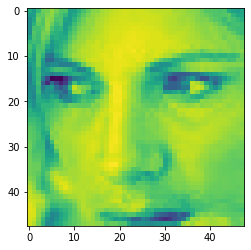

In [4]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [5]:
checkpoint = ModelCheckpoint('DenseNet121.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            batch_size=batch_size,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

2023-01-23 16:33:37.074998: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-23 16:33:37.075036: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-23 16:33:37.143085: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2023-01-23 16:33:37.178720: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-23 16:33:37.178864: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [6]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(512, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(256, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

model.summary()
# for i, layer in enumerate(model.layers):
#     print(i, layer.name, layer.trainable)

2023-01-23 16:33:37.367885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 16:33:37.465660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 16:33:37.466457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 16:33:37.467451: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
_____________________________

In [7]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
# from IPython.display import Image
# Image("model.png")

In [8]:
%%time

model_history = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=val_generator, 
                                validation_steps=len(val_generator),
                                epochs=epochs,
                                callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint])

Beginning training
Epoch 1/100
Learning rate:  1e-04


2023-01-23 16:33:43.898395: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-23 16:33:55.300864: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/599 [..............................] - ETA: 3:00:12 - loss: 3.1828 - accuracy: 0.1458

2023-01-23 16:34:02.013979: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-23 16:34:02.014054: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/599 [..............................] - ETA: 5:11 - loss: 3.1575 - accuracy: 0.1458   

2023-01-23 16:34:02.541758: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-23 16:34:02.545800: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-23 16:34:02.746010: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 3030 callback api events and 3027 activity events. 
2023-01-23 16:34:02.853711: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-23 16:34:02.950999: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs-01232023163337/train/plugins/profile/2023_01_23_16_34_02

2023-01-23 16:34:03.011603: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs-01232023163337/train/plugins/profile/2023_01_23_16_34_02/c035eebfc6f9.trace.json.gz
2023-01-23 16:34:03.129131: I tensorflow/core/profiler/rpc/client/save_profile.cc:136]

599/599 [==============================] - 275s 430ms/step - loss: 2.4976 - accuracy: 0.4129 - val_loss: 2.6076 - val_accuracy: 0.3113
End of epoch 0. Learning rate: 1e-04

Epoch 00001: val_accuracy improved from -inf to 0.31133, saving model to DenseNet121.h5
Epoch 2/100
Learning rate:  1e-04
599/599 [==============================] - 196s 327ms/step - loss: 2.0065 - accuracy: 0.5574 - val_loss: 1.8248 - val_accuracy: 0.5982
End of epoch 1. Learning rate: 1e-04

Epoch 00002: val_accuracy improved from 0.31133 to 0.59816, saving model to DenseNet121.h5
Epoch 3/100
Learning rate:  1e-04
599/599 [==============================] - 184s 308ms/step - loss: 1.8153 - accuracy: 0.5956 - val_loss: 1.7328 - val_accuracy: 0.5962
End of epoch 2. Learning rate: 1e-04

Epoch 00003: val_accuracy did not improve from 0.59816
Epoch 4/100
Learning rate:  1e-04
599/599 [==============================] - 185s 308ms/step - loss: 1.6818 - accuracy: 0.6205 - val_loss: 1.6349 - val_accuracy: 0.6241
End of epo

In [9]:
history = pd.DataFrame(model_history.history)
history.to_csv('DenseNet121.csv', index=False)
history

,loss,accuracy,val_loss,val_accuracy,lr
0,2.497603,0.412937,2.607560,0.311334,1.000000e-04
1,2.006476,0.557351,1.824768,0.598162,1.000000e-04
2,1.815326,0.595562,1.732758,0.596213,1.000000e-04
3,1.681832,0.620502,1.634940,0.624060,1.000000e-04
4,1.573874,0.638963,1.538954,0.639098,1.000000e-04
5,1.489014,0.649901,1.468141,0.650515,1.000000e-04
6,1.409920,0.663590,1.415619,0.644946,1.000000e-04
7,1.330530,0.678533,1.389571,0.655528,1.000000e-04
8,1.272862,0.691769,1.346745,0.661654,1.000000e-04
9,1.206700,0.701104,1.291485,0.665831,1.000000e-04


<h2>Plotting<h2>

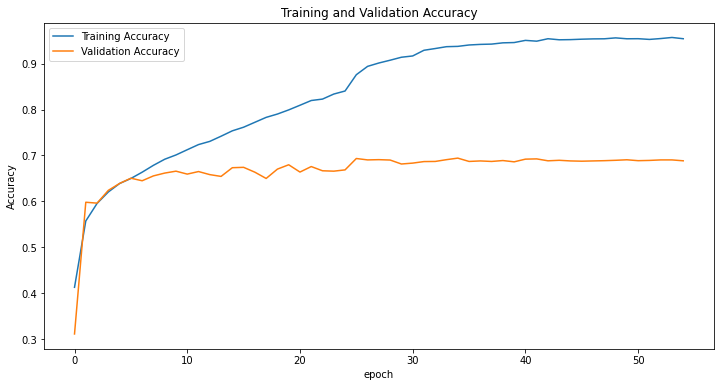

In [10]:
f, ax=plt.subplots(figsize=(12,6))
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

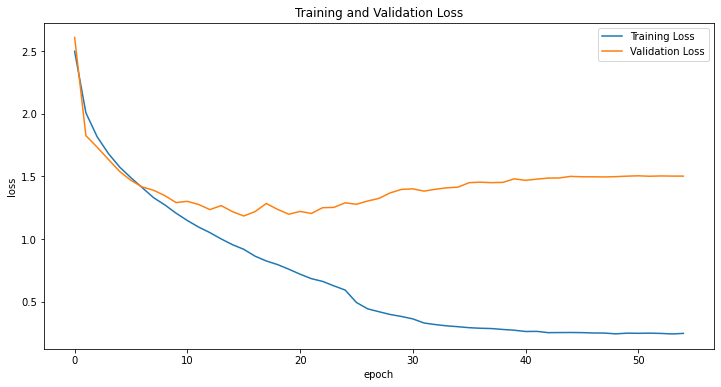

In [11]:
f, ax=plt.subplots(figsize=(12,6))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

<h2>Model Evaluation<h2>

In [12]:
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

Classification Report
              precision    recall  f1-score   support

       angry       0.64      0.66      0.65       479
     disgust       0.83      0.69      0.75        55
        fear       0.61      0.54      0.57       512
       happy       0.90      0.90      0.90       887
     neutral       0.66      0.70      0.68       616
         sad       0.56      0.58      0.57       623
    surprise       0.83      0.82      0.83       415

    accuracy                           0.71      3587
   macro avg       0.72      0.70      0.71      3587
weighted avg       0.71      0.71      0.71      3587



In [13]:
#confusion matrix
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true=test_generator.classes


from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred)
cm

array([[317,   5,  53,  10,  34,  56,   4],
       [  9,  38,   2,   1,   2,   2,   1],
       [ 54,   0, 277,  14,  44,  88,  35],
       [ 16,   0,   7, 800,  30,  22,  12],
       [ 30,   2,  28,  23, 430,  98,   5],
       [ 58,   0,  65,  25, 104, 360,  11],
       [ 12,   1,  20,  19,   8,  14, 341]])

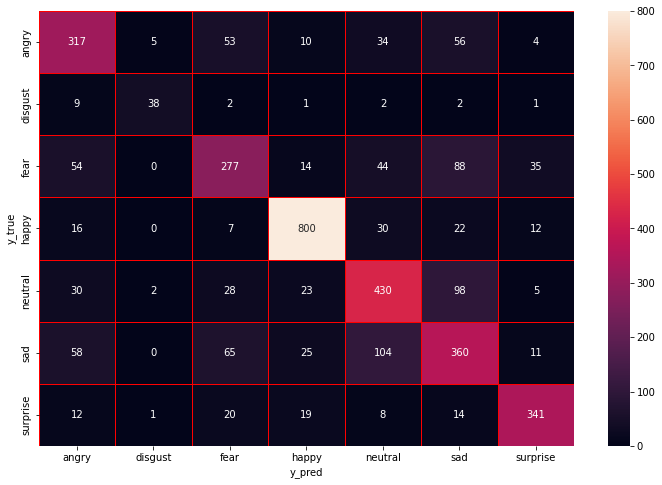

In [14]:
f, ax=plt.subplots(figsize=(12,8))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax,xticklabels=target_names, yticklabels=target_names,)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [15]:
model.evaluate(test_generator , verbose = 1)

75/75 [==============================] - 6s 76ms/step - loss: 1.3249 - accuracy: 0.7145


[1.3249295949935913, 0.7145246863365173]

In [16]:
# #Test the model
# model = load_model('./DenseNet201.h5')

# test_image='../input/fer2013/test/happy/PrivateTest_11155116.jpg'
# image_result=Image.open(test_image)

# from tensorflow.keras.preprocessing import image
# test_image=image.load_img(test_image,target_size=(targetx, targety))
# test_image=image.img_to_array(test_image)
# test_image=test_image/255
# test_image=np.expand_dims(test_image,axis=0)

# result=model.predict(test_image)
# print(np.argmax(result))
# Categories =target_names
# image_result=plt.imshow(image_result)
# plt.title(Categories[np.argmax(result)])
# plt.show()